In [1]:
import torch
import numpy as np
import torch.nn.functional as F
from captum.attr import LRP
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule, IdentityRule
from gcommand_loader import spect_loader
import matplotlib.pyplot as plt
import os
import torch.nn as nn

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def do_lrp(model, wav_path):
    # load spectogram from wav file
    spect = spect_loader(path=wav_path, window_size=.02, window_stride=.01, window='hamming', normalize=True)

    # add betch dimension 
    input = spect.unsqueeze(1)

    # get the predicted class
    target_class = torch.argmax(model(input)).item()
    print(target_class)

    layers = list(model._modules["features"])
    num_layers = len(layers)

    for idx_layer in range(1, num_layers):
        if isinstance(layers[idx_layer], nn.Conv2d):
            if idx_layer <= 2:
                # apply identityRule on conv layers near the input to preserve the activations as they are
                setattr(layers[idx_layer], "rule", IdentityRule())
            else:
                # apply Alpha1_Beta0_Rule on conv layes near the output to propagates only positive relevance.
                setattr(layers[idx_layer], "rule", Alpha1_Beta0_Rule())


    # apply EpsilonRule on fc layers close the the output
    setattr(model._modules["fc1"], "rule", EpsilonRule(epsilon=1e-6))
    setattr(model._modules["fc2"], "rule", EpsilonRule(epsilon=1e-6))
    
    lrp = LRP(model)

    attributions_lrp = lrp.attribute(input, target=target_class)

    # convert attributions to numpy for visualization
    attributions_np = attributions_lrp.squeeze().cpu().detach().numpy()

    # convert your input spectrogram to numpy for visualization
    input_np = input.squeeze().cpu().detach().numpy()

    # fix dimansions for visualization
    input_np_3d = np.expand_dims(input_np, axis=-1)
    attributions_np_3d = np.expand_dims(attributions_np, axis=-1)

    stress = 'Initial' if target_class == 1 else 'Final'
    title = [f"Spectogram With Stress Location: [{stress}]", "Corresponding Heat Map"]
    # Visualize the attribution map using visualize_image_attr
    _ = viz.visualize_image_attr_multiple(attr=attributions_np_3d,
                                original_image=input_np_3d,
                                methods=["original_image", "heat_map"],
                                show_colorbar=True,
                                signs=["all", "positive"],
                                outlier_perc=2, titles=title,
                                fig_size=(6,6))


In [3]:
# Load the checkpoint
checkpoint_path = '/app/src/GCommandsPytorch/checkpoint/ckpt.t7'

checkpoint = torch.load(checkpoint_path)
device = torch.device('cpu')
# Load model state from checkpoint
model = checkpoint['net']
model.to(device)

# If model was saved using DataParallel, unwrap it if needed
if isinstance(model, torch.nn.DataParallel):
    model = model.moduleba
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

/app/src/GCommandsPytorch/model.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


1


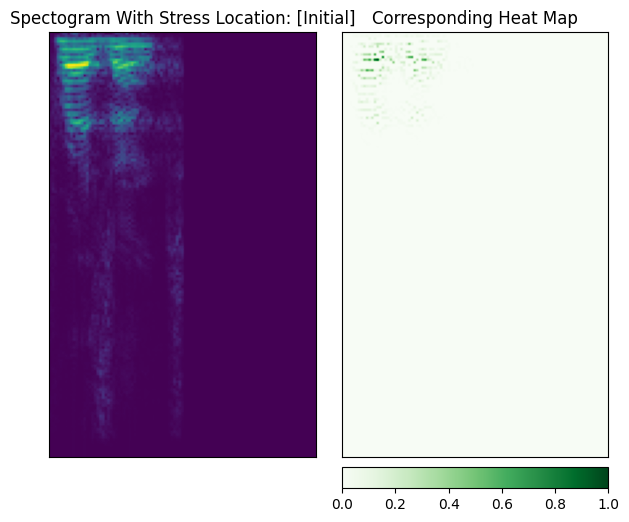

/app/src/GCommandsPytorch/model.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


1


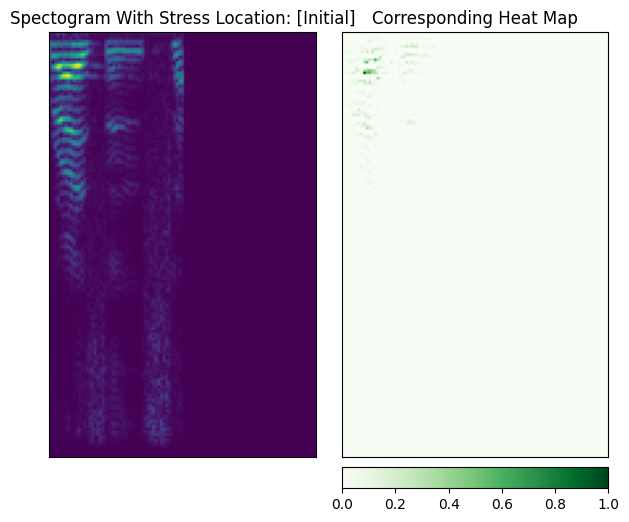

/app/src/GCommandsPytorch/model.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


1


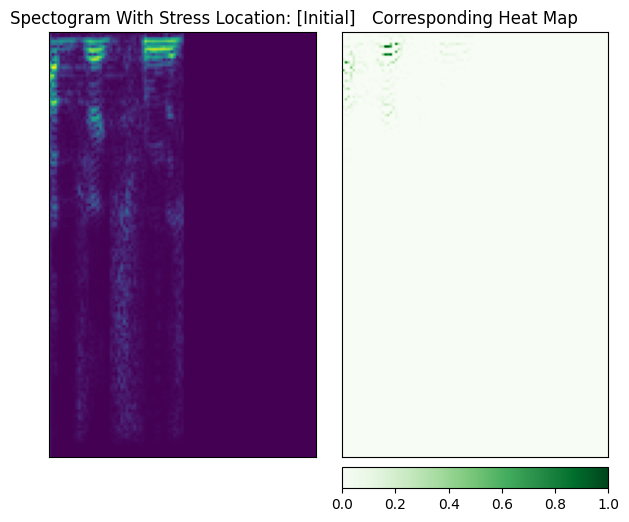

/app/src/GCommandsPytorch/model.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


1


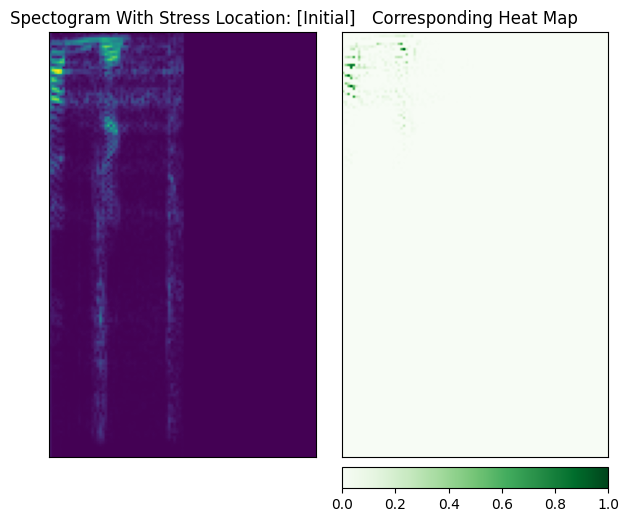

/app/src/GCommandsPytorch/model.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


1


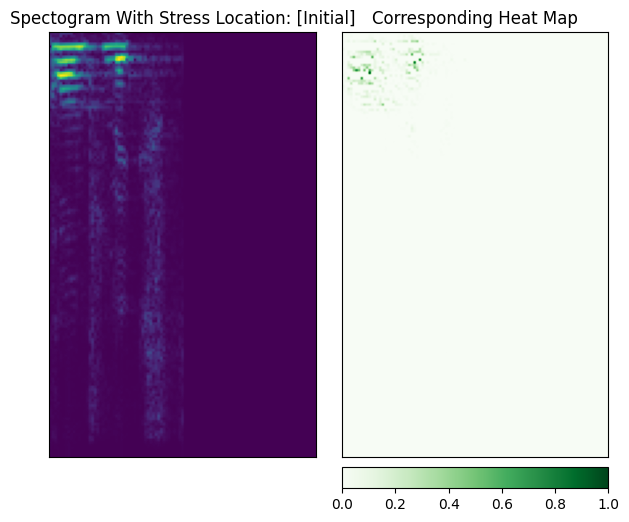

/app/src/GCommandsPytorch/model.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


1


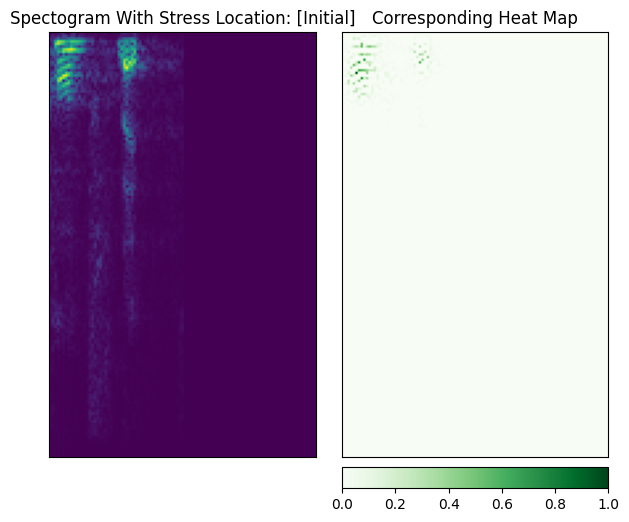

/app/src/GCommandsPytorch/model.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


0


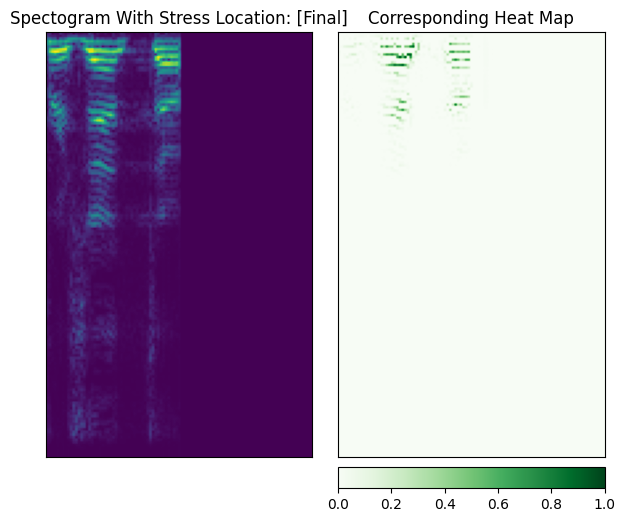

/app/src/GCommandsPytorch/model.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


0


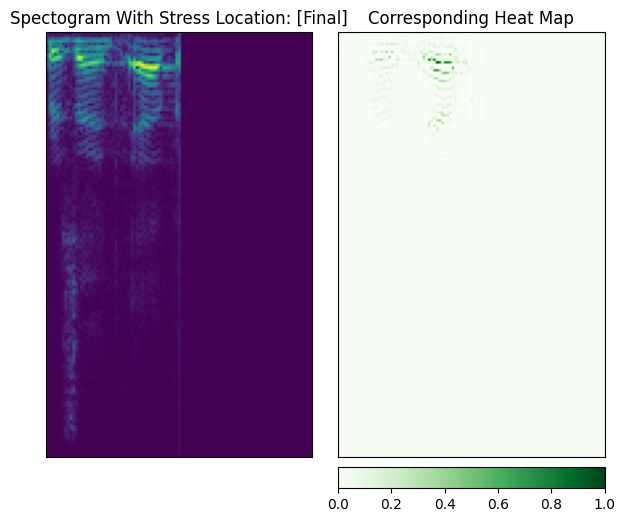

/app/src/GCommandsPytorch/model.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


0


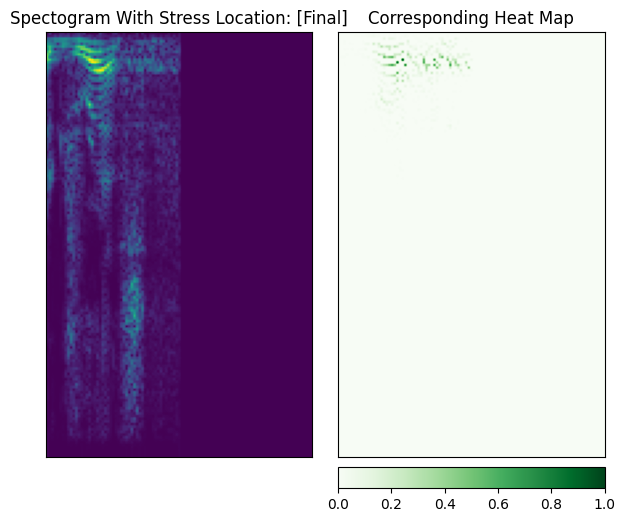

/app/src/GCommandsPytorch/model.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


0


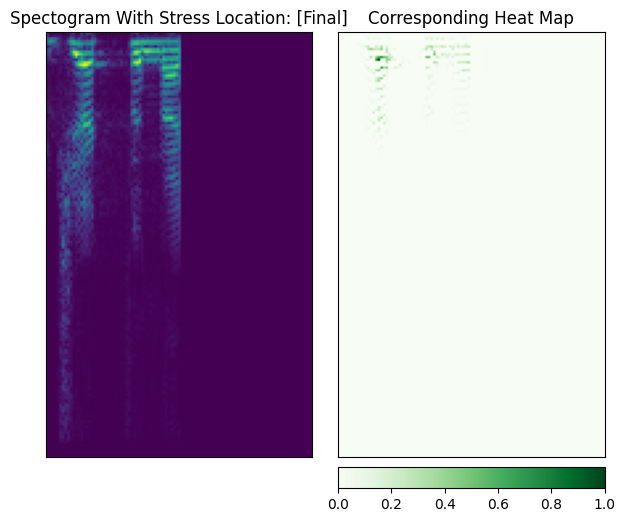

/app/src/GCommandsPytorch/model.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


0


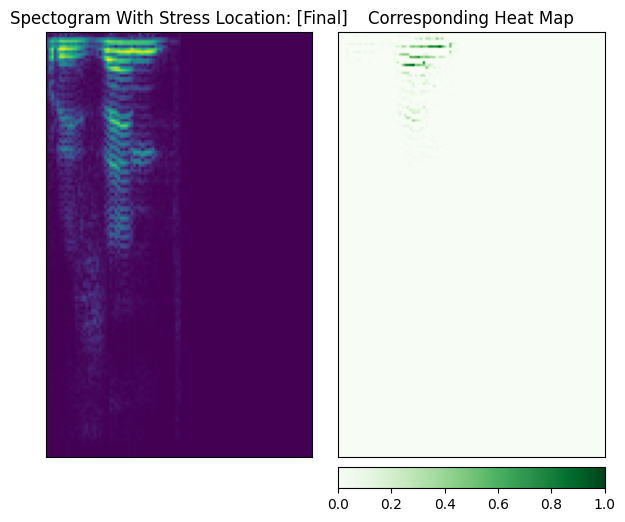

/app/src/GCommandsPytorch/model.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


0


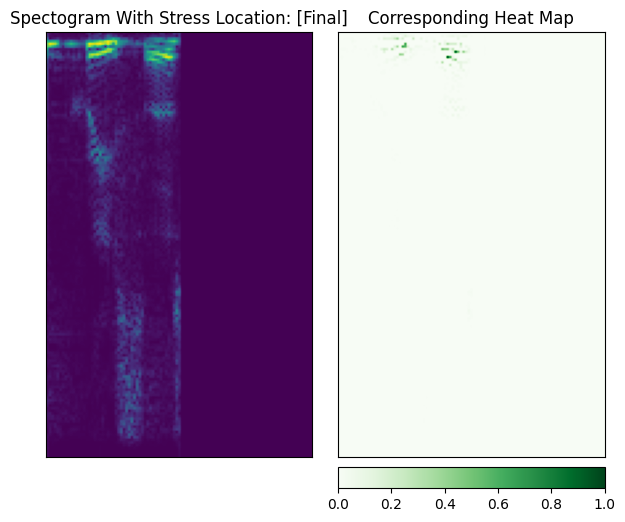

In [4]:
is_wav_path1 = "/app/src/GCommandsPytorch/test/IS/392.wav"
is_wav_path2 = "/app/src/GCommandsPytorch/test/IS/101.wav"
is_wav_path3 = "/app/src/GCommandsPytorch/test/IS/220.wav"
is_wav_path4 = "/app/src/GCommandsPytorch/test/IS/240.wav"
is_wav_path5 = "/app/src/GCommandsPytorch/test/IS/261.wav"
is_wav_path6 = "/app/src/GCommandsPytorch/test/IS/262.wav"
fs_wav_path1 = "/app/src/GCommandsPytorch/test/FS/244.wav"
fs_wav_path2 = "/app/src/GCommandsPytorch/test/FS/1127.wav"
fs_wav_path3 = "/app/src/GCommandsPytorch/test/FS/2469.wav"
fs_wav_path4 = "/app/src/GCommandsPytorch/test/FS/3064.wav"
fs_wav_path5 = "/app/src/GCommandsPytorch/test/FS/1238.wav"
fs_wav_path6 = "/app/src/GCommandsPytorch/test/FS/1412.wav"
do_lrp(model, is_wav_path1)
do_lrp(model, is_wav_path2)
do_lrp(model, is_wav_path3)
do_lrp(model, is_wav_path4)
do_lrp(model, is_wav_path5)
do_lrp(model, is_wav_path6)
do_lrp(model, fs_wav_path1)
do_lrp(model, fs_wav_path2)
do_lrp(model, fs_wav_path3)
do_lrp(model, fs_wav_path4)
do_lrp(model, fs_wav_path5)
do_lrp(model, fs_wav_path6)

In [97]:
wav_path = "/app/src/GCommandsPytorch/test/right/65.wav"
noise_path = "/app/scripts/noise.wav"

sample_wav = download_asset(wav_path)
sample_noise = download_asset(noise_path)

speech, _ = torchaudio.load(sample_wav)
noise, _ = torchaudio.load(sample_noise)
noise = noise[:, : speech.shape[1]]

snr_dbs = torch.tensor([20, 10])
noisy_speeches = F.add_noise(speech, noise, snr_dbs)

noisy_speech1 = noisy_speeches[0:1]
print(noisy_speech1.shape)

Audio(noisy_speech1, rate=16000)

torch.Size([1, 8000])


In [14]:
FS_path = f"/root/FS"
IS_path = f"/root/IS"

with open('/root/testing_list.txt', 'a') as test_file:
    with open('/root/validation_list.txt', 'a') as valid_file:
        for i, file in enumerate (os.listdir(FS_path)):
            if os.path.isfile(os.path.join(FS_path, file)):
                if (i / len(os.listdir(FS_path))) <= 0.1:
                    test_file.write(f"FS/{file}\n")
                elif (i / len(os.listdir(FS_path))) > 0.1 and (i / len(os.listdir(FS_path))) <= 0.2:
                    valid_file.write(f"FS/{file}\n")
                else:
                    pass

with open('/root/testing_list.txt', 'a') as test_file:
    with open('/root/validation_list.txt', 'a') as valid_file:
        for i, file in enumerate (os.listdir(IS_path)):
            if os.path.isfile(os.path.join(IS_path, file)):
                if (i / len(os.listdir(IS_path))) <= 0.1:
                    test_file.write(f"IS/{file}\n")
                elif (i / len(os.listdir(IS_path))) > 0.1 and (i / len(os.listdir(IS_path))) <= 0.2:
                    valid_file.write(f"IS/{file}\n")
                else:
                    pass


In [14]:
import pyarrow.parquet as pq
import pyarrow as pa

# Path to your Parquet file
file_path = '/app/new_datasets/TEDLIUM/labeld_audio.parquet'

table = pq.read_table(file_path)

# Convert the table to a Pandas DataFrame
df = table.to_pandas()

list_of_tuples = [(row['audio'], row['label']) for index, row in df.iterrows()]

In [15]:
len(list_of_tuples)

8558

In [12]:
import wave
import numpy as np

for i, sample in enumerate(list_of_tuples):
    output_name = f"{i}.wav"
    if sample[1] == 1:
        path = "/root/FS"
    else:
        path = "/root/IS"
    
    full_path = f"{path}/{output_name}"
    raw_data_int16 = (sample[0]*32767).astype(np.int16)

    with wave.open(full_path, 'wb') as wav_file:
        wav_file.setnchannels(1)
        wav_file.setsampwidth(2)
        wav_file.setframerate(16000)
        wav_file.writeframes(raw_data_int16.tobytes())

In [2]:
from torchaudio.utils import download_asset
import torch
import torchaudio
import torchaudio.functional as F

# returns new waveform after applying low-pass filter
def apply_lowpass(wav_path: str):
    if not wav_path.endswith(".wav"):
        raise ValueError(f"the file: {wav_path} in not a .wav file")
    
    sample_wav = download_asset(wav_path)
    waveform, sample_rate = torchaudio.load(sample_wav, channels_first=False)
    effect = ",".join(
        [
        "lowpass=frequency=300:poles=1",  # apply single-pole lowpass filter
        # "atempo=0.8",  # reduce the speed
        # "aecho=in_gain=0.8:out_gain=0.9:delays=200:decays=0.3|decays=0.3"
        # Applying echo gives some dramatic feeling
        ],
    )
    effector = torchaudio.io.AudioEffector(effect=effect)
    return effector.apply(waveform, sample_rate)
    
# add noise to the speech waveform at 10,20 and 3 SNR levels.
def add_noisw_with_snr(wav_path: str):
    if not wav_path.endswith(".wav"):
        raise ValueError(f"the file: {wav_path} in not a .wav file")
    
    noise_path = "./noise.wav"
    sample_noise = download_asset(noise_path)
    noise, _ = torchaudio.load(sample_noise)

    sample_wav = download_asset(wav_path)
    speech, sample_rate = torchaudio.load(sample_wav)
    noise = noise[:, : speech.shape[1]]

    # define SNR values and apply noise
    snr_dbs = torch.tensor([20, 10, 3])
    noisy_speeches = F.add_noise(speech, noise, snr_dbs)

    # separate noisy speeches for each SNR level
    noisy_speech_20db = noisy_speeches[0:1]
    noisy_speech_10db = noisy_speeches[1:2]
    noisy_speech_3db = noisy_speeches[2:3]
    return noisy_speech_20db, noisy_speech_10db, noisy_speech_3db, sample_rate   

In [12]:
# dir_path = "/app/src/GCommandsPytorch/valid/FS"

# for i,file_name in enumerate(os.listdir(dir_path)):
#     if (not file_name.endswith("_filterd.wav")) and (not file_name.endswith("noise.wav")) and file_name.endswith(".wav"):
#         file_path = f"{dir_path}/{file_name}"
#         new_wav = apply_lowpass(file_path)
#         file_num = file_name.rstrip(".wav")

#         output_path = f"/app/src/GCommandsPytorch/valid/FS2/{file_num}_filterd.wav"

#         torchaudio.save(output_path, src=new_wav, sample_rate=16000, channels_first=False, format='wav')

In [20]:
# dir_path = "/app/src/GCommandsPytorch/valid/FS"
# noise_path = "/app/scripts/background_noise.wav"

# sample_noise = download_asset(noise_path)

# noise, _ = torchaudio.load(sample_noise)

# for i,file_name in enumerate(os.listdir(dir_path)):
#     if (not file_name.endswith("_filterd.wav")) and (not file_name.endswith("noise.wav")) and file_name.endswith(".wav"):
#         file_path = f"{dir_path}/{file_name}"
#         sample_wav = download_asset(file_path)
#         speech, sample_rate = torchaudio.load(sample_wav)
#         noise = noise[:, : speech.shape[1]]

#         # define SNR values and apply noise
#         snr_dbs = torch.tensor([20, 10, 3])
#         noisy_speeches = F.add_noise(speech, noise, snr_dbs)

#         # separate noisy speeches for each SNR level
#         noisy_speech_20db = noisy_speeches[0:1]
#         noisy_speech_10db = noisy_speeches[1:2]
#         noisy_speech_3db = noisy_speeches[2:3]

#         file_num = file_name.rstrip(".wav")

#         output_path_20db = f"/app/src/GCommandsPytorch/valid/FS2/{file_num}_20db_noise.wav"
#         output_path_10db = f"/app/src/GCommandsPytorch/valid/FS2/{file_num}_10db_noise.wav"
#         output_path_3db = f"/app/src/GCommandsPytorch/valid/FS2/{file_num}_3db_noise.wav"
 
#         torchaudio.save(output_path_20db, src=noisy_speech_20db, sample_rate=sample_rate, channels_first=True, format='wav')
#         torchaudio.save(output_path_10db, src=noisy_speech_10db, sample_rate=sample_rate, channels_first=True, format='wav')
#         torchaudio.save(output_path_3db, src=noisy_speech_3db, sample_rate=sample_rate, channels_first=True, format='wav')